# pyGAM Datasets Demo

This notebook demonstrates all the available datasets in the pyGAM demo collection.
Each dataset is loaded and visualized with appropriate GAM models.


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, LogisticGAM, PoissonGAM, s, f, te
from load_datasets import *

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Motorcycle Accident Data (mcycle)
Time series data of motorcycle accidents with acceleration measurements.


mcycle data: X shape (133, 1), y shape (133,)


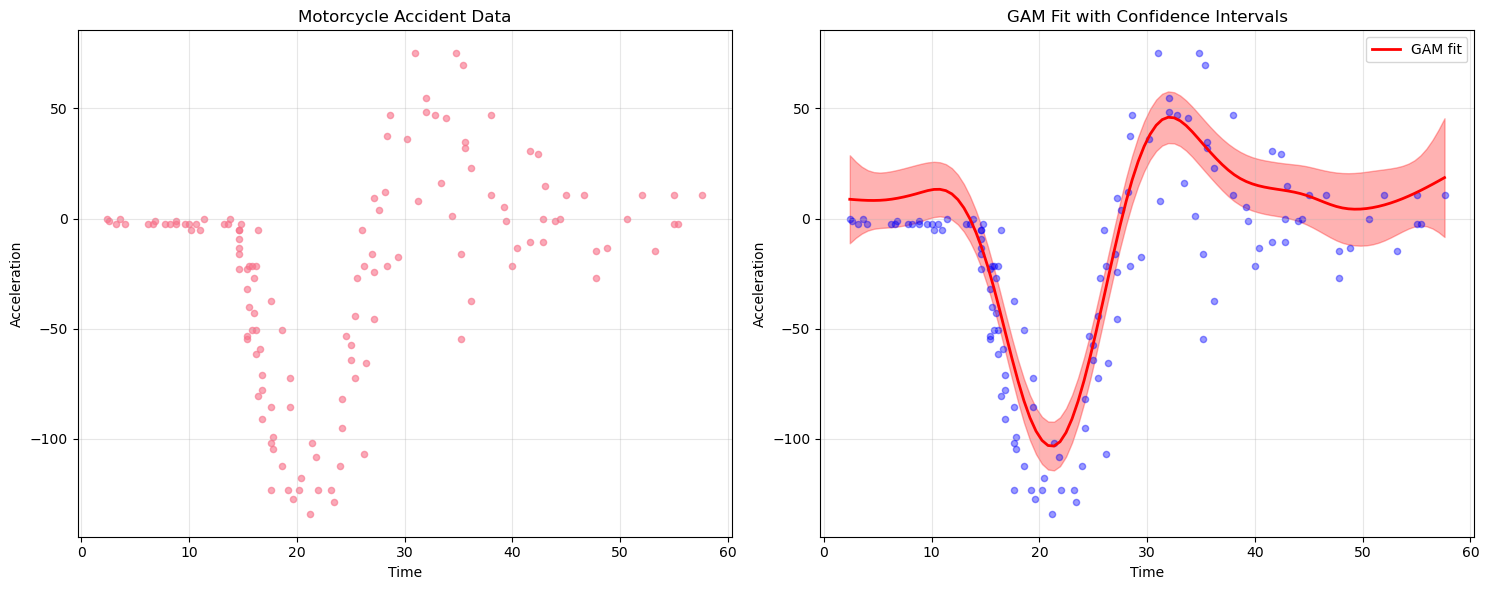

R² score: 0.7922
AIC: 1931.60


In [ ]:

# Load mcycle data
X, y = mcycle(return_X_y=True)

print(f"mcycle data: X shape {X.shape}, y shape {y.shape}")

# Fit GAM
gam = LinearGAM(s(0))
gam.fit(X, y)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Raw data
ax1.scatter(X, y, alpha=0.6, s=20)
ax1.set_xlabel('Time')
ax1.set_ylabel('Acceleration')
ax1.set_title('Motorcycle Accident Data')
ax1.grid(True, alpha=0.3)

# GAM fit
XX = gam.generate_X_grid(term=0)  # Generate a grid of values for the predictor variable for plotting
pdep, confi = gam.partial_dependence(term=0, X=XX, width=0.95)  # Calculate partial dependence and 95% confidence interval for the predictor
ax2.plot(XX, pdep, 'r-', linewidth=2, label='GAM fit')  # Plot the fitted GAM curve in red
ax2.fill_between(XX.flatten(), confi[:, 0], confi[:, 1], alpha=0.3, color='red')  # Shade the area between confidence bounds for the fit
ax2.scatter(X, y, alpha=0.4, s=20, color='blue')  # Overlay the original data as blue scatter points
ax2.set_xlabel('Time')  # Set x-axis label to 'Time'
ax2.set_ylabel('Acceleration')  # Set y-axis label to 'Acceleration'
ax2.set_title('GAM Fit with Confidence Intervals')  # Give the plot a descriptive title
ax2.legend()  # Show the legend to identify the fitted curve
ax2.grid(True, alpha=0.3)  # Add a lightly transparent grid for readability

plt.tight_layout()
plt.show()

print(f"R² score: {gam.score(X, y):.4f}")
print(f"AIC: {gam.statistics_['AIC']:.2f}")


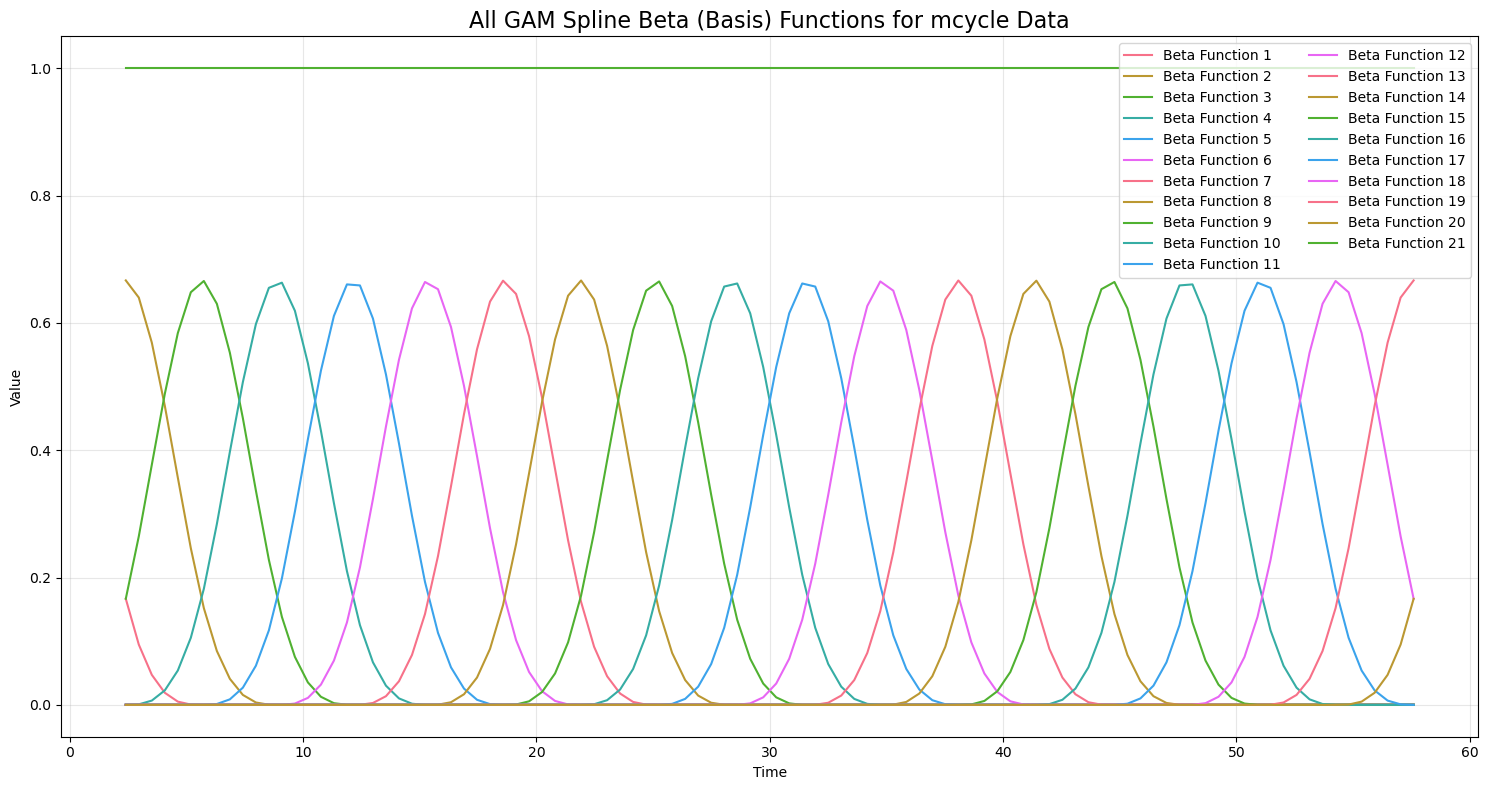

In [5]:

# Plot all the beta (basis) functions used in the GAM's spline approximation for the mcycle data on the same figure
fig, ax = plt.subplots(figsize=(15, 8))

# Get the model matrix (basis functions) for the term
# Always use dense arrays for plotting (pyGAM may return sparse matrices)
basis = gam._modelmat(XX)
if hasattr(basis, "toarray"):
    basis = basis.toarray()

num_basis = basis.shape[1]
for i in range(num_basis):
    ax.plot(XX.flatten(), basis[:, i], label=f'Beta Function {i+1}')

ax.set_title('All GAM Spline Beta (Basis) Functions for mcycle Data', fontsize=16)
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend(loc='upper right', ncol=2, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## 3. PoissonGAM for Event Density Modeling
Modeling event density in time sequences using the coal mining disaster data.


coal data: X shape (191, 1), y shape (191,)
Time range: 1851.2 to 1962.2
Total events: 191
Density data: 42 time bins with events


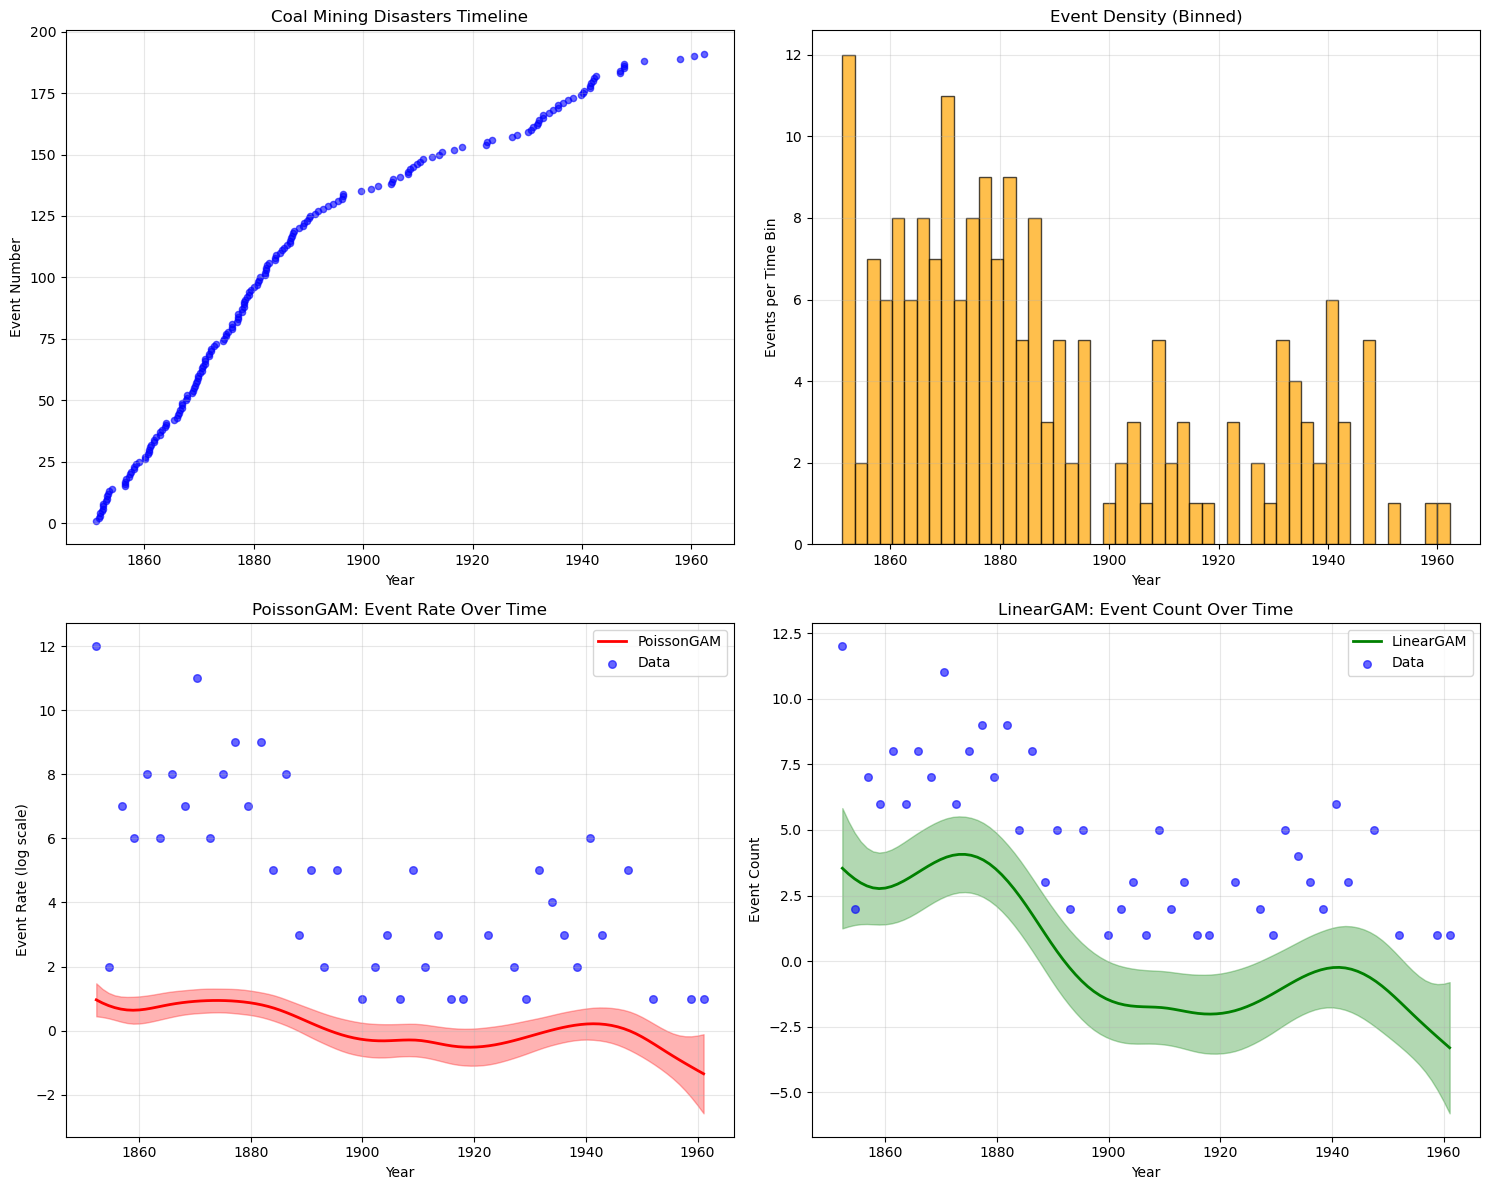


Model Performance Comparison:
PoissonGAM - Deviance: 26.37, AIC: 180.32
LinearGAM  - Deviance: 33.35, AIC: 215.96

Predicted Event Rates:
Year 1850: PoissonGAM rate = 10.73, LinearGAM count = 8.06
Year 1900: PoissonGAM rate = 2.48, LinearGAM count = 2.56
Year 1950: PoissonGAM rate = 2.70, LinearGAM count = 2.91
Year 2000: PoissonGAM rate = 0.02, LinearGAM count = -6.45


In [6]:
# Load coal mining disaster data
X, y = coal(return_X_y=True)
print(f"coal data: X shape {X.shape}, y shape {y.shape}")
print(f"Time range: {X.min():.1f} to {X.max():.1f}")
print(f"Total events: {len(y)}")

# Create time bins for density modeling
# We'll model the rate of events per year
time_bins = np.linspace(X.min(), X.max(), 50)  # 50 time bins
bin_counts = np.zeros(len(time_bins)-1)
bin_centers = np.zeros(len(time_bins)-1)

# Count events in each time bin
for i in range(len(time_bins)-1):
    mask = (X.flatten() >= time_bins[i]) & (X.flatten() < time_bins[i+1])
    bin_counts[i] = np.sum(mask)
    bin_centers[i] = (time_bins[i] + time_bins[i+1]) / 2

# Remove empty bins for cleaner visualization
non_zero_mask = bin_counts > 0
X_density = bin_centers[non_zero_mask].reshape(-1, 1)
y_density = bin_counts[non_zero_mask]

print(f"Density data: {len(X_density)} time bins with events")

# Fit PoissonGAM for event density
gam_poisson = PoissonGAM(s(0))  # Smooth term for time
gam_poisson.fit(X_density, y_density)

# Also fit LinearGAM for comparison
gam_linear = LinearGAM(s(0))
gam_linear.fit(X_density, y_density)

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Raw event timeline
axes[0,0].scatter(X, y, alpha=0.6, s=20, color='blue')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Event Number')
axes[0,0].set_title('Coal Mining Disasters Timeline')
axes[0,0].grid(True, alpha=0.3)

# Event density (binned)
axes[0,1].bar(bin_centers[non_zero_mask], y_density, width=bin_centers[1]-bin_centers[0], 
              alpha=0.7, color='orange', edgecolor='black')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Events per Time Bin')
axes[0,1].set_title('Event Density (Binned)')
axes[0,1].grid(True, alpha=0.3)

# PoissonGAM fit
XX = gam_poisson.generate_X_grid(term=0)
pdep_poisson, confi_poisson = gam_poisson.partial_dependence(term=0, X=XX, width=0.95)
axes[1,0].plot(XX, pdep_poisson, 'r-', linewidth=2, label='PoissonGAM')
axes[1,0].fill_between(XX.flatten(), confi_poisson[:, 0], confi_poisson[:, 1], alpha=0.3, color='red')
axes[1,0].scatter(X_density, y_density, alpha=0.6, s=30, color='blue', label='Data')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Event Rate (log scale)')
axes[1,0].set_title('PoissonGAM: Event Rate Over Time')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# LinearGAM comparison
pdep_linear, confi_linear = gam_linear.partial_dependence(term=0, X=XX, width=0.95)
axes[1,1].plot(XX, pdep_linear, 'g-', linewidth=2, label='LinearGAM')
axes[1,1].fill_between(XX.flatten(), confi_linear[:, 0], confi_linear[:, 1], alpha=0.3, color='green')
axes[1,1].scatter(X_density, y_density, alpha=0.6, s=30, color='blue', label='Data')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Event Count')
axes[1,1].set_title('LinearGAM: Event Count Over Time')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model comparison
print(f"\nModel Performance Comparison:")
print(f"PoissonGAM - Deviance: {gam_poisson.statistics_['deviance']:.2f}, AIC: {gam_poisson.statistics_['AIC']:.2f}")
print(f"LinearGAM  - Deviance: {gam_linear.statistics_['deviance']:.2f}, AIC: {gam_linear.statistics_['AIC']:.2f}")

# Predict event rates for specific years
test_years = np.array([[1850], [1900], [1950], [2000]])
poisson_rates = gam_poisson.predict(test_years)
linear_counts = gam_linear.predict(test_years)

print(f"\nPredicted Event Rates:")
for year, poisson_rate, linear_count in zip(test_years.flatten(), poisson_rates, linear_counts):
    print(f"Year {year}: PoissonGAM rate = {poisson_rate:.2f}, LinearGAM count = {linear_count:.2f}")


### PoissonGAM for Event Density Modeling:

**What is PoissonGAM?**
- Designed for **count data** and **event rates**
- Uses Poisson distribution with log link function
- Perfect for modeling events over time (accidents, failures, arrivals)

**Key Concepts:**
- **Event Density**: Rate of events per unit time
- **Time Binning**: Group events into time intervals for density calculation
- **Poisson Distribution**: Natural choice for count data
- **Log Link**: Ensures positive predictions (rates can't be negative)

**Why PoissonGAM vs LinearGAM?**
- **PoissonGAM**: Models event rates (counts/time), handles count data properly
- **LinearGAM**: Models continuous values, can predict negative counts (unrealistic)
- **PoissonGAM**: Uses log link, better for rate modeling
- **LinearGAM**: Uses identity link, assumes normal distribution

**Applications:**
- Accident rates over time
- Equipment failure rates
- Customer arrival rates
- Disease incidence rates
- Crime rates by time/location


In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_poisson_deviance, mean_squared_error

# Use 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

poisson_deviances = []
linear_deviances = []
poisson_MSEs = []
linear_MSEs = []

X_ = X  # features (matrix)
y_ = y  # target/counts

for train_idx, test_idx in kf.split(X_):
    X_train, X_test = X_[train_idx], X_[test_idx]
    y_train, y_test = y_[train_idx], y_[test_idx]

    gam_poisson_cv = PoissonGAM().fit(X_train, y_train)
    gam_linear_cv = LinearGAM().fit(X_train, y_train)

    y_pred_poisson = gam_poisson_cv.predict(X_test)
    y_pred_linear = gam_linear_cv.predict(X_test)

    # Poisson deviance (lower is better)
    pd_pois = mean_poisson_deviance(y_test, y_pred_poisson)
    pd_lin = mean_poisson_deviance(y_test, np.clip(y_pred_linear, 1e-6, None))  # ensure >0 for deviance
    poisson_deviances.append(pd_pois)
    linear_deviances.append(pd_lin)

    # MSE for reference
    mse_pois = mean_squared_error(y_test, y_pred_poisson)
    mse_lin = mean_squared_error(y_test, y_pred_linear)
    poisson_MSEs.append(mse_pois)
    linear_MSEs.append(mse_lin)

print("\n5-Fold Cross-Validation Results:")
print(f"Mean PoissonGAM Deviance: {np.mean(poisson_deviances):.2f} ± {np.std(poisson_deviances):.2f}")
print(f"Mean LinearGAM Deviance:  {np.mean(linear_deviances):.2f} ± {np.std(linear_deviances):.2f}")
print(f"\nMean PoissonGAM MSE:      {np.mean(poisson_MSEs):.2f} ± {np.std(poisson_MSEs):.2f}")
print(f"Mean LinearGAM MSE:        {np.mean(linear_MSEs):.2f} ± {np.std(linear_MSEs):.2f}")



5-Fold Cross-Validation Results:
Mean PoissonGAM Deviance: 0.11 ± 0.05
Mean LinearGAM Deviance:  0.08 ± 0.03

Mean PoissonGAM MSE:      1.79 ± 0.23
Mean LinearGAM MSE:        2.01 ± 0.32


## Summary of pyGAM Commands Used

This notebook demonstrates the following pyGAM functionality:

### **Imports**
- `LinearGAM` - For continuous response variables with normal distribution
- `LogisticGAM` - For binary classification (imported but not used in this notebook)
- `PoissonGAM` - For count data and event rates with Poisson distribution
- `s()` - Smooth spline term constructor
- `f()` - Factor term constructor (imported but not used)
- `te()` - Tensor product term constructor (imported but not used)

### **Model Creation**
- `LinearGAM(s(0))` - Create a LinearGAM with a smooth spline term for the first feature
- `PoissonGAM(s(0))` - Create a PoissonGAM with a smooth spline term for the first feature

### **Model Fitting**
- `gam.fit(X, y)` - Fit the GAM model to training data
  - `X`: Feature matrix (n_samples, n_features)
  - `y`: Target vector (n_samples,)

### **Model Evaluation**
- `gam.score(X, y)` - Calculate R² score (coefficient of determination)
- `gam.statistics_['AIC']` - Access Akaike Information Criterion
- `gam.statistics_['deviance']` - Access model deviance

### **Prediction & Visualization**
- `gam.generate_X_grid(term=0)` - Generate a grid of values for a specific term (useful for plotting)
- `gam.partial_dependence(term=0, X=XX, width=0.95)` - Calculate partial dependence function and confidence intervals
  - Returns: `(partial_dependence, confidence_intervals)`
  - `width=0.95` specifies 95% confidence interval
- `gam.predict(X)` - Make predictions on new data
- `gam._modelmat(XX)` - Get the model matrix (basis functions) for visualization

### **Smooth Terms**
- `s(0)` - Smooth spline term for the first feature (index 0)
  - Automatically determines optimal smoothness via penalized likelihood

### **Key Concepts Demonstrated**
1. **LinearGAM**: Used for continuous response data (motorcycle acceleration)
2. **PoissonGAM**: Used for count/rate data (coal mining disasters)
3. **Partial Dependence**: Visualizing the effect of individual features
4. **Confidence Intervals**: Quantifying uncertainty in predictions
5. **Basis Functions**: Understanding the spline basis used in the model
